Let's now have a look at cleaning up the FLUX values by looking at IVAR and MASK.

In [1]:
import astropy.table as apy
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

In [2]:
spectra = apy.Table.read('data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits', format='fits', hdu=1)

Code below produces corrected FLUX values for 10 random stars. Uncorrected values will "stick out" on the plots in orange so that we can visually see what gets corrected to what.

Bad mask values are reproduced as vertical gray stripes.

Processing star 4-13520               


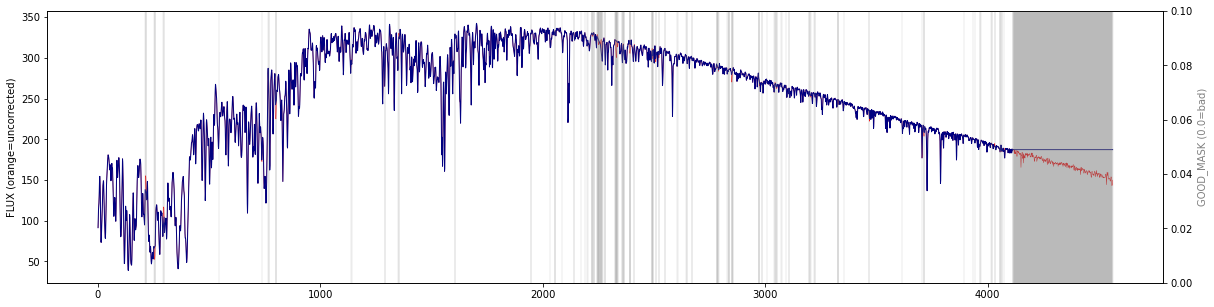

In [3]:
random_spectra = spectra[np.char.startswith(
            spectra['MANGAID'].data, '4-13520'.encode('ascii'))]#np.random.choice(len(spectra), size=10)]
random_spectra['FLUX_CORR'] = random_spectra['FLUX'].copy()

# Interpolate over broken pixels. Good example of test target is 7-17015390
for s in random_spectra:
    print('Processing star %s' % s['MANGAID'])
    good_mask = ((s['IVAR'] != 0) & (s['MASK'] == 0))
    good_indices = np.where(good_mask)[0]
    if len(good_indices) == len(s['FLUX']):
        print('All points good')
        continue

    if len(good_indices) == 0:
        print('All points bad')
        continue

    first_good = s['FLUX'][np.where(good_mask)[0][0]]
    last_good = s['FLUX'][np.where(good_mask)[0][-1]]
    _,ax = plt.subplots(figsize=(20,5))
    # Could also use fill_value='extrapolate', but it gives a weird effect of the line shooting out in a weird direction
    fint = interpolate.interp1d(
        good_indices, s['FLUX'][good_mask], kind='linear', bounds_error=False, copy=False, fill_value=(first_good, last_good))
    #ax.plot(np.arange(len(s['FLUX'])), fint(np.arange(len(s['FLUX']))), color='purple', alpha=0.5, linewidth=2)

    s['FLUX_CORR'] = np.where(
        good_mask, s['FLUX'], fint(np.arange(len(s['FLUX']))))
    # Extrapolation can create nagatives. Clamp to 0.0
    s['FLUX_CORR'][s['FLUX_CORR'] < 0.0] = 0.0

    ax.set_ylabel('FLUX (orange=uncorrected)', color='black')
    ax.plot(s['FLUX'], color='red', linewidth=0.5)
    ax.plot(s['FLUX_CORR'], color='navy', linewidth=1)

    axmask = ax.twinx()
    axmask.set_ylabel('GOOD_MASK (0.0=bad)', color='gray')
    axmask.set_ylim(0.0, 0.1)
    axmask.vlines(np.arange(len(s['FLUX'])), good_mask, color='gray', alpha=0.1, ymax=1.0)

    plt.show()

Let's play with the spectrums now.

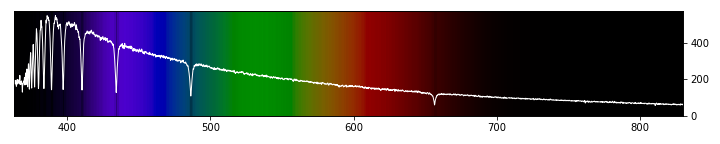

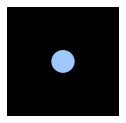

In [29]:
import colour
import colour.plotting as cplt
import io
from IPython.display import Image, display

# From https://colour.readthedocs.io/en/v0.4.1/tutorial.html

star = spectra[np.char.startswith(
    spectra['MANGAID'].data, '3-159177389'.encode('ascii'))][0]

spectrum_data = dict(
    zip(star['WAVE']/10.0, star['FLUX']))
spectrumd = colour.SpectralDistribution(spectrum_data)

plotdata = io.BytesIO()
fig,ax = plt.subplots(figsize=(10,2))
line = ax.twinx()
line.plot(star['WAVE']/10.0, star['FLUX'], color='white', zorder=-1, linewidth=1.0)
# Settings from https://github.com/colour-science/colour/blob/master/colour/plotting/common.py
try:
    cplt.plot_single_sd(spectrumd, modulate_colours_with_sd_amplitude=True, equalize_sd_amplitude=True,
        y_label='', x_label='', title='', y_ticker=False, figure=fig, axes=ax, filename=plotdata)
except Exception:
    line.plot(star['WAVE']/10.0, star['FLUX'],
                color='black', zorder=0, linewidth=0.5)
    plt.savefig(plotdata, format='png')
plt.close()
display(Image(plotdata.getvalue()))


# Something I found used in https://colab.research.google.com/drive/1NRcdXSCshivkwoU2nieCvC3y14fx1X4X#sandboxMode=true&scrollTo=ozsKpUMmIrif
with colour.utilities.domain_range_scale('1'):
    # Some options https://github.com/colour-science/colour/blob/master/colour/colorimetry/datasets/cmfs.py
    # Also https://github.com/colour-science/colour/blob/master/colour/colorimetry/datasets/illuminants/sds.py
    # https://www.image-engineering.de/library/technotes/753-cie-standard-illuminants says E is flat, pinned to 100.0
    # e.g. cmfs = colour.MSDS_CMFS['CIE 1931 2 Degree Standard Observer'], illuminant = colour.SDS_ILLUMINANTS['E']
    XYZ = colour.sd_to_XYZ(spectrumd.align(colour.SPECTRAL_SHAPE_DEFAULT))
    RGB = colour.XYZ_to_sRGB(XYZ / 100, illuminant=colour.CCS_ILLUMINANTS['cie_2_1931']['E'])

    # Colour render from https://colab.research.google.com/drive/1NRcdXSCshivkwoU2nieCvC3y14fx1X4X#sandboxMode=true&scrollTo=ozsKpUMmIrif
    # with colour.utilities.domain_range_scale('1'):
    #    XYZ = colour.sd_to_XYZ(self.spectral_distribution.align(
    #        colour.SPECTRAL_SHAPE_DEFAULT))
    #    RGB = colour.XYZ_to_sRGB(
    #        XYZ, illuminant=colour.CCS_ILLUMINANTS['cie_2_1931']['E'])

    star = plt.Circle(
        (0.5, 0.5), 0.1, color=colour.algebra.normalise_maximum(RGB))
    cosmos = plt.Rectangle((0.0, 0.0), 1.0, 1.0, color=[0, 0, 0])

    _, ax = plt.subplots(figsize=(2, 2))
    ax.set_axis_off()
    ax.add_patch(cosmos)
    ax.add_patch(star)
    plt.show()

Some things noticed (separately presented below in this notebook):

* Sometimes interpolation is really good, for example in 60-1624506444102499968 or 5-76263, where a low-value that would otherwise be intepreted as spectral line gets fixed to something more reasonable
* Original data can also have negative Flux numbers that are supposedly correct, e.g. 3-160330227 or 3-152987861 or 60-3426311229834881024
* some corrected values are worse than original bad values. Example can be seen in 4-13520 or 5-28373 or 7-17887318, where there is a big block of supposedly bad data that looks fine, but gets interpolated into a runaway line.
* some bad pixels look like they aren't broken at all, e.g. in 3-22616370. Perhaps I need to look into good_mask to see why this is treated as bad pixel - maybe IVAR is so close to zero it gets interpreted as 0.0? Or I don't understand the meaning of MASK?
* 7-18076292 and 3-38173779 produce out-of range spectrum RGB values

Some other stars I found:

* fun green star 60-598873918878952704 on pics
* dim orange star 3-35422112 and 60-3426311229834881024
* red star 7-9216400
* blue 7-11356573
* extra cool 3-20884757 (coolest byt INPUT_TEFF)
* extra hot 3-159177389 (by INPUT_TEFF again)
* extreme FLUX values 53-1342794 (nearly 100,000)

Couple of ways of dealing with bad extrapolations:

* disable extrapolation
* use uncorrected FLUX values and hope for the best
* feed the algorithm with both FLUX and mask values, and let it figure out which one does what
* use some sort of flat extrapolation

Let's now implement the flux interpolation and spectrums into stars.py, and try it out.

In [5]:
import stars
from IPython.display import HTML

sl = stars.StarLoader('data/mastarall-v3_1_1-v1_7_7.fits', 'data/mastar-combspec-v3_1_1-v1_7_7-lsfpercent99.5.fits')

7-9451666


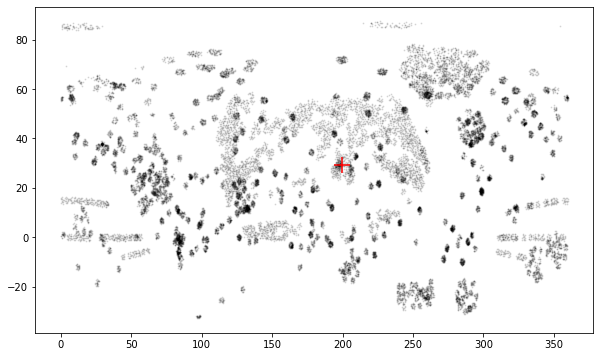

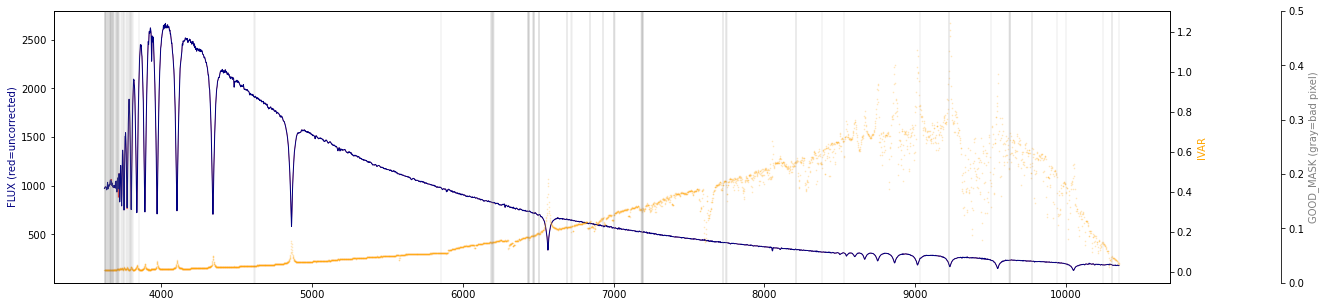

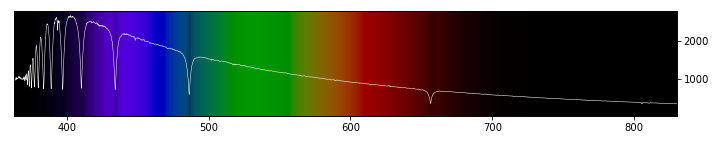

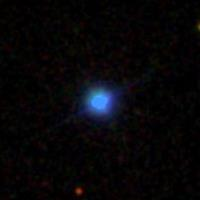

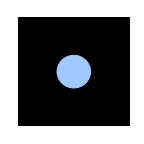

In [15]:
s = sl.get_star('7-9451666')
#or s = sl.random_star()
print(s.get_mangaid())
sl.locate_star(s)
s.show_spectrum()
s.show_spectrum_strip()
s.show_star_image()
s.show_simulated_star_image()

Here is the problematic extrapolated spectrum:

4-13520


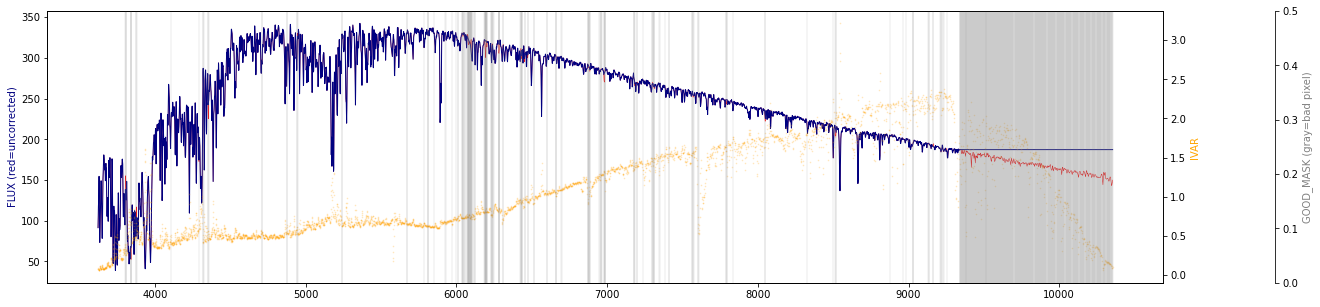

In [7]:
s = sl.get_star('4-13520')
print(s.get_mangaid())
s.show_spectrum()

And here is the negative FLUX values (see red sticking out below zero on the far left):

60-3426311229834881024


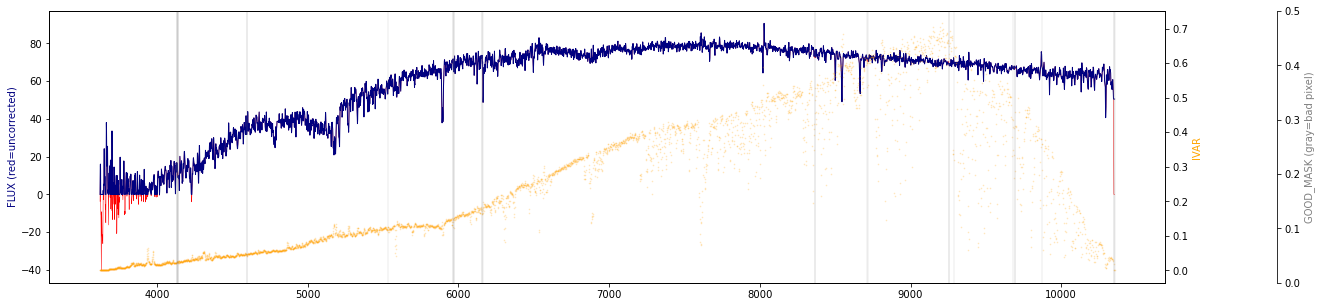

In [13]:
s = sl.get_star('60-3426311229834881024')
print(s.get_mangaid())
s.show_spectrum()

This one interpolates over an area that's seemingly ok:

3-22616370


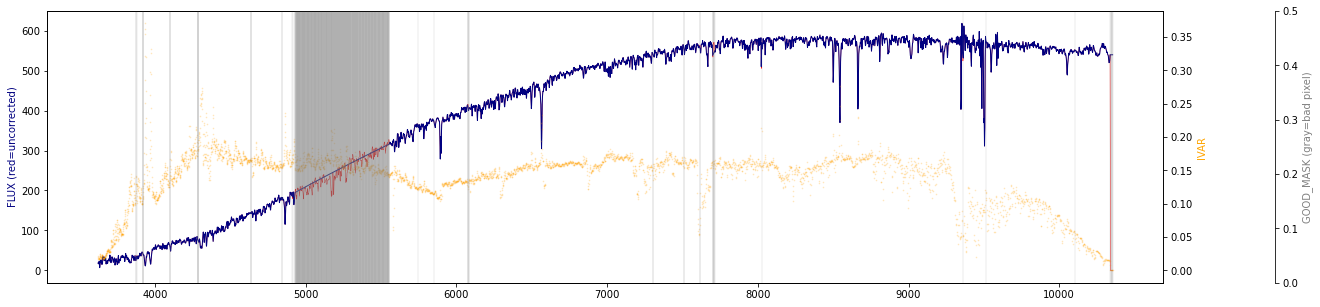

In [9]:
s = sl.get_star('3-22616370')
print(s.get_mangaid())
s.show_spectrum()

We can also create a table like earlier on.

MANGAID,Image,Spectrum,Input T,Input source
7-27916355,,,4587K,LAMOST_CANNON
3-106010614,,,4705K,LAMOST
3-109638534,,,6609K,SEGUE
3-11907157,,,6555K,SEGUE
7-24947280,,,5989K,LAMOST
7-26844600,,,5949K,LAMOST
7-17896914,,,3756K,APOGEE
7-26833349,,,4944K,APOGEE
7-13649054,,,6355K,APOGEE
3-139691004,,,3945K,APOGEE

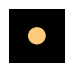
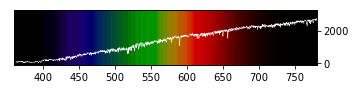
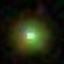
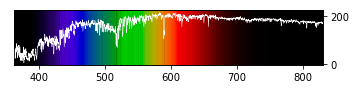
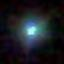
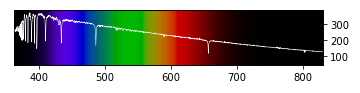
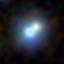
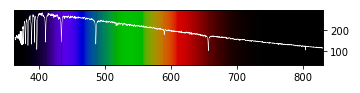
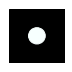
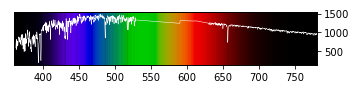
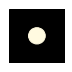
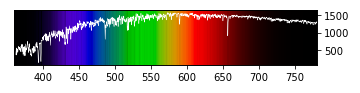
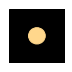
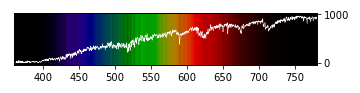
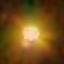
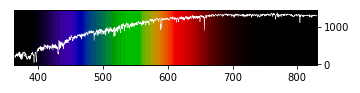
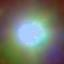
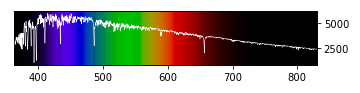
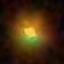
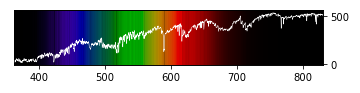

In [31]:
o = ''
for i in np.arange(1,11):
    s = sl.random_star(mask=(sl.stars['INPUT_TEFF']>0))
    o += s.get_table_line()
display(HTML(sl.wrap_in_table(o)))